In [428]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Utils

In [429]:
def split_data(X, Y, Ntrain):
    N = len(X)

    idx = np.arange(N)
    np.random.shuffle(idx)

    train_idx = idx[:Ntrain]
    test_idx = idx[Ntrain:]

    Xtrain = X[train_idx]
    Ytrain = Y[train_idx]

    Xtest = X[test_idx]
    Ytest = Y[test_idx]

    return (Xtrain, Ytrain), (Xtest, Ytest)

#vander matrix
def vander(X, K):
  N = len(X)
  V = np.ones((N,K))
  for k in range(1,K):
    V[:,k] = X**k
  return V

#err

In [430]:
# The gradient_descent implementation.
# We don't know the final length of the arrays because the gradient can
# converge early than expected. So we put a limit on the maxium number of iteration
def gd(f, grad_f, w0, data, K, kmax, tolf, tolx, alpha,l = None):
    # Initialization
    k = 0
    n = int(w0.shape[0])
    w = np.zeros((kmax + 1, n))
    f_val = np.zeros((kmax + 1, ))
    grads = np.zeros((kmax + 1, n))
    err = np.zeros((kmax + 1, ))
    x, y = data

    # Assign the values for the first iteration, start point(k=0)
    w[k, :] = w0
    f_val[k] = f(w0,K,x,y,l)
    grads[k, :] = grad_f(w0,K,x,y,l)
    # the err is a vector, because it's the norm of the gradient
    err[k] = np.linalg.norm(grads[k, :])

    # Choose step size
    alpha = alpha

    # Handle the condition for the first iteration (x[k,:] - x[k-1,:])

    if k == 0:
        w[k-1, :] = np.ones((n,))
        #x[k-1, :] = x[-1, :]


    # Start the iterations
    while ((k < kmax) and (err[k] >= (tolf * err[0])) and (np.linalg.norm(w[k,:] - w[k-1,:]) >= tolx)):
        # Update the value of x
        w[k+1, :] = w[k, :] - alpha * grads[k, :]

        # Update the values of the actual iteration
        k = k+1
        f_val[k] = f(w[k, :],K, x, y,l)
        grads[k, :] = grad_f(w[k, :],K, x, y,l)
        err[k] = np.linalg.norm(grads[k, :])

    # Truncate the vectors that are (eventually) too long because maybe we have reached the convergence before the stopping value kmax
    w = w[:k+1, :]
    f_val = f_val[:k+1]
    grads = grads[: k+1]
    err = err[: k+1]

    return w, k, f_val, grads, err

In [431]:
def sgd(f, grad_f, w0, data,K, batch_size, n_epochs, alpha, l = None):
    # Extract data
    x, y = data
    #print(x.shape)
    # Initialize
    w_val = np.zeros((n_epochs + 1, int(w0.shape[0])))
    f_val = np.zeros((n_epochs + 1,))
    grads = np.zeros((n_epochs + 1, int(w0.shape[0]) ))
    err = np.zeros((n_epochs + 1,))

    # Assign values for the first iteration
    w_val[0, :] = w0
   # print(w_val[0,:].shape)
    f_val[0] = f(w0,K, x, y,l)
    grads[0, :] = grad_f(w0,K,x, y,l)
    err[0] = np.linalg.norm(grads[0, :])

    # Choose step size
    alpha = alpha

    w = w0
    # Copy the data
    x_copy = np.copy(x)
    y_copy = np.copy(y)
    # Compute the number of batch iteration for each epoch
    N = len(x)
    n_iter_per_epoch = int(N / batch_size)
    # For each epoch
    for epoch in range(1, n_epochs+1):

        # Inner iterations(for each batch)
        for k in range(n_iter_per_epoch):
            # Random indices that composes our mini-batch (look at np.random.choice)
            batch_idx = np.random.choice(len(x), batch_size, replace = False )
           # print(batch_idx)
            # Split
            mask = np.ones((len(x), ), dtype=bool)
          #  print(x.shape[1])
            mask[batch_idx] = False

            x_batch = x[~mask]
            y_batch = y[~mask]

            x = x[mask]
            y = y[mask]

            # Update weights
            w = w - alpha * grad_f(w,K, x_batch, y_batch,l)
        # Refill the data
        x = np.copy(x_copy)
        y = np.copy(y_copy)

        # Update the values of the vector after each epoch
        w_val[epoch] = w
        f_val[epoch] = f(w_val[epoch, :],K, x, y,l)
        grads[epoch, :] = grad_f(w_val[epoch, :],K, x, y,l)
        err[epoch] = np.linalg.norm(grads[epoch, :])
       # print(f"Epoch: {epoch}, Error: {err[epoch]}")
    # Truncate the excess
    w_val  = w_val[:epoch, :]
    f_val = f_val[:epoch]
    grads = grads[:epoch, :]
    err = err[:epoch]

    return w_val, f_val, grads, err

#Test problem

In [432]:
#set random state for code reproducibiliy
seed = 42
np.random.seed(seed)
#get the value K
#inp_K = int(input("Enter a K>0: "))
#if(inp_K<=0):
#  raise Exception("Please put a value greater than 0")
inp_K = 6
w_true = np.ones((inp_K,))
w_true.shape

(6,)

In [433]:
a = 0
b = 1
N = 100
X = np.random.uniform(a,b,N)
#X = np.linspace(a,b,N)
V = vander (X,inp_K)
print(V.shape)

(100, 6)


In [434]:
#random Gaussian noise
#sigma = 0.5
variance = 0.8
mean = 0
noise = np.random.normal(mean,variance,N)
#built Y
Y = V @ w_true + noise
Y.shape

(100,)

In [435]:
Ntrain = int(0.8*N)
(Xtrain, Ytrain), (Xtest, Ytest) = split_data(X, Y, Ntrain)

#print(Xtrain.shape, Xtest.shape)

#MLE and MAP

In [436]:
def test(data, w, K):
  X,Y = data
  Y_pred = vander(X,K) @ w
  #print(len(Y), len(Y_pred))
  err = (np.linalg.norm(Y_pred-Y,2))**2 / len(X)
  return err

def err_w(w_true,w_approx):
  t = len(w_true)
  l = len(w_approx)
  wp_true = np.pad(w_true, (0,len(w_approx) - len(w_true)), 'constant')
  error = np.linalg.norm(w_approx-wp_true) / np.linalg.norm(wp_true)
  return error

In [437]:
#MLE
# Value of the loss
def loss(w, K, X, Y,l):
  N = len(X)
  if(l != None):
    raise Exception('The lamba factor should be none for MLE')
  return 0.5*(np.linalg.norm(vander(X,K)@ w - Y) ** 2)

# Value of the gradient
def grad_loss(w,K, X, Y,l):
  if(l != None):
    raise Exception('The lamba factor should be none for MLE')
  return vander(X,K).T @(vander(X,K)@ w - Y)


#MAP (l stands for the regularization parameter)
def loss_map(w,K,X,Y,l):
  if(l==None):
    print(f'l is none')
    return -1
  else:
    return  0.5 * ((np.linalg.norm(vander(X, K) @w - Y)**2) + (l/2) * np.linalg.norm(w)**2)

def grad_loss_map(w,K,X,Y,l):
    return  vander(X, K).T @ ((vander(X, K) @ w) - Y) + l * w

In [438]:
def mle(data, K, algo = 'SGD'):
  w0 = np.zeros((K,))
  #w0 = np.random.normal(0, 0.7, K)
  X,Y = data
  if(algo == 'SGD'):
    w, f_val, grads, err = sgd(loss, grad_loss, w0, data,K, batch_size = 16, n_epochs = 30, alpha = 1e-3)
    return w[-1,:]
  if(algo == 'GD'):
    w, k, f_val, grads, err = gd(loss, grad_loss, w0, data, K, kmax = 100, tolf = 1e-6 , tolx = 1e-5, alpha = 1e-3)
    return w[-1, :]
  if(algo == 'normal'):
    #size phi: NxK,size of w = (KxN @ NxK) @KxN @ N --> KxK @ KxN @ N = K x N @ N x 1 = Kx1
    phi = vander(X,K)
    #w = np.linalg.inv(phi.T @ (phi))@ phi.T @Y
    w = np.linalg.solve(phi.T@phi, phi.T@Y)
    return w
  else:
    raise Exception("The algorithm should be 'SGD', 'GD' or 'normal'")

In [439]:
def mape(data, K, l, algo = 'SGD'):
  w0 = np.zeros((K,))
  #w0 = np.random.normal(0, 0.8, K)
  if(algo == 'SGD'):
    w, f_val, grads, err = sgd(loss_map, grad_loss_map, w0, data,K, batch_size = 16, n_epochs = 20, alpha = 1e-3, l = l)
    return w[-1,:]
  if(algo == 'GD'):
    w, k, f_val, grads, err = gd(loss_map, grad_loss_map, w0, data, K, kmax = 100, tolf = 1e-6 , tolx = 1e-5, alpha = 1e-3, l = l)
    return w[-1, :]
  if(algo == 'normal'):
    phi = vander(X,K)
    w = np.linalg.solve(phi.T@phi +l*np.identity(K), phi.T@Y)
    return w
  else:
    raise Exception("The algorithm should be 'SGD', 'GD' or 'normal'")

In [440]:
def show_plot(train_data, test_data, w, real_K, test_K,MLE = True, l=None):
  (Xtrain, Ytrain) = train_data
  (Xtest, Ytest) = test_data
  plt.plot(Xtrain, Ytrain, 'ro', markersize = 3)
  plt.plot(Xtest, Ytest, 'bo', markersize = 3)
  #interpolation line
  x_line = np.linspace(0,1,1000)
  y_line = vander(x_line,test_K) @ w
  plt.plot(x_line,y_line)
  if(MLE):
    algo = 'MLE'
  else:
    algo = 'MAP'
  if(l):
    plt.title(f'{algo}: real_K: {real_K}, test_K: {test_K}, lambda: {l}')
  else:
    plt.title(f'{algo}: real_K: {real_K}, test_K: {test_K}')
  plt.legend(["Train set","Test set"])
  plt.grid()
  plt.show()

def show_plot_lambda(train_data, test_data, real_K, test_K, lam, algo='SGD'):
  (Xtrain, Ytrain) = train_data
  (Xtest, Ytest) = test_data
  plt.plot(Xtrain, Ytrain, 'ro', markersize = 3)
  plt.plot(Xtest, Ytest, 'bo', markersize = 3)
  for l in lam:
    w = mape(train_data, test_K, l, algo = algo)
    #interpolation line
    x_line = np.linspace(0,1,1000)
    y_line = vander(x_line,test_K) @ w
    plt.plot(x_line,y_line)

  plt.title(f'{algo}: real_K: {real_K}, test_K: {test_K}')
  plt.legend(["Train set","Test set"]+lam)
  plt.grid()
  plt.show()


In [441]:
def visualize_model(train_data, test_data, K, MLE = True, algo = 'SGD', l = None):
  #K = [2,4,10,20,25]
  best_k = K[0]
  small_error = 0
  for test_K in K:
    if(MLE):
      w = mle(train_data, K = test_K, algo = algo)
    else:
      if(l ==None):
        raise Exception('It is possible to compute the MAP only giving a l value >=0.')
      w = mape(train_data, K = test_K, l = l, algo = 'SGD')
    train_error = test(train_data, w, test_K)
    test_error = test(test_data, w, test_K)
    #first iteration initialization
    if(test_K == K[0]):
      small_error = test_error
    print(f"Abs error on training data is: {train_error}")
    print(f"Abs error on test data is: {test_error}")
    if(test_K > real_K):
      w_error = err_w(w_true,w)
      print(f'Error on w:{w_error}')
    if(test_error < small_error):
      best_k = test_K
      small_error = test_error
    show_plot(train_data,test_data,w,real_K, test_K, MLE = MLE, l=l)
    print('\n')
  print(f'The best test K for which we have the smallest error is {best_k}')

In [442]:
def compare_error(train_data, test_data, Kmax = 20, MLE = True, algo = 'SGD', l = None):
  #plot error of training and test set wrt K
  Ks= range(1,Kmax+1)
  err_train = []
  err_test = []
  for test_K in Ks:
    if(MLE):
      w = mle(train_data, K = test_K, algo = algo)
    else:
      if(l ==None):
        raise Exception('It is possible to compute the MAP only giving a l value.')
      w = mape(train_data, K = test_K, l = l, algo = 'SGD')
    train_error = test(train_data, w, test_K)
    test_error = test(test_data, w, test_K)
    err_train.append(train_error)
    err_test.append(test_error)
    #print(f"Abs error on training data is: {train_error}")
    #print(f"Abs error on test data is: {test_error}")
    #show_plot(train_data,test_data,w,real_K, test_K)

  diff = abs(np.array(err_train) - np.array(err_test))
  best_k = np.argmin(diff)+1
  print("The best tradeoff is given by K =",best_k)

  plt.plot(Ks,err_train,'r-')
  plt.plot(Ks,err_test,'y-')
  plt.legend(["Error on train set","Error on test set"])
  plt.xlabel("K")
  plt.ylabel("Absolute error")
  plt.title('Error between training set and error set for different value of K')
  plt.show()

##MLE

###SGD

Abs error on training data is: 0.6120621276208387
Abs error on test data is: 0.6253619426925193


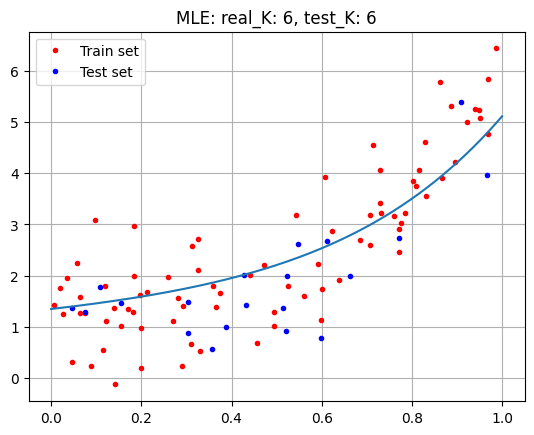

In [443]:
train_data = (Xtrain, Ytrain)
real_K = inp_K
test_K = inp_K
w = mle(train_data, K = test_K, algo = 'SGD')
test_data = (Xtest,Ytest)
train_error = test(train_data, w, test_K)
test_error = test(test_data, w, test_K)
print(f"Abs error on training data is: {train_error}")
print(f"Abs error on test data is: {test_error}")
show_plot(train_data,test_data,w,real_K, test_K, MLE = True)

Visualize the model for different K

Abs error on training data is: 1.396940442556811
Abs error on test data is: 1.1070171951675998


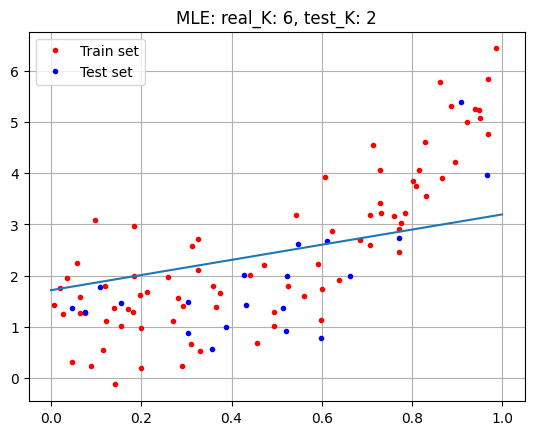



Abs error on training data is: 0.7817197783564162
Abs error on test data is: 0.7618168601042469


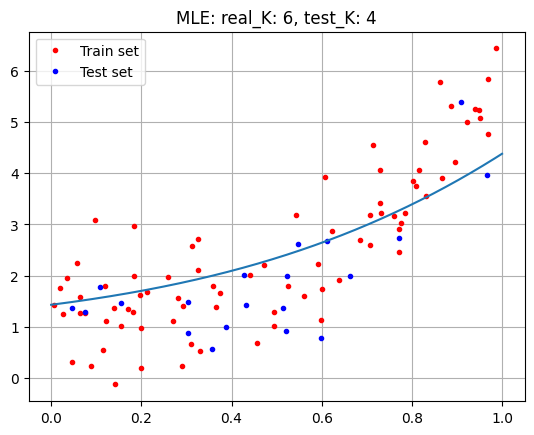



Abs error on training data is: 0.5409407987669124
Abs error on test data is: 0.5663378947250168
Error on w:0.47100114248326846


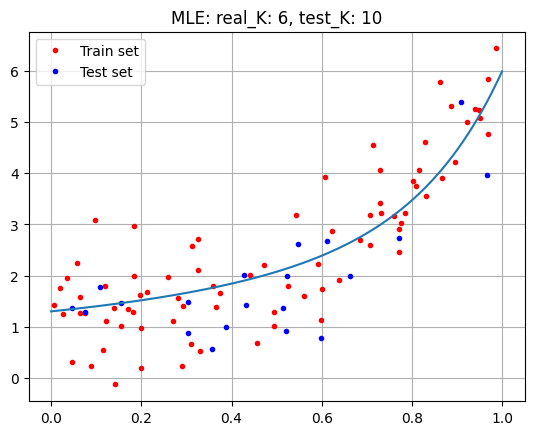



Abs error on training data is: 0.5572284559632383
Abs error on test data is: 0.5903909298880188
Error on w:0.5238386156936973


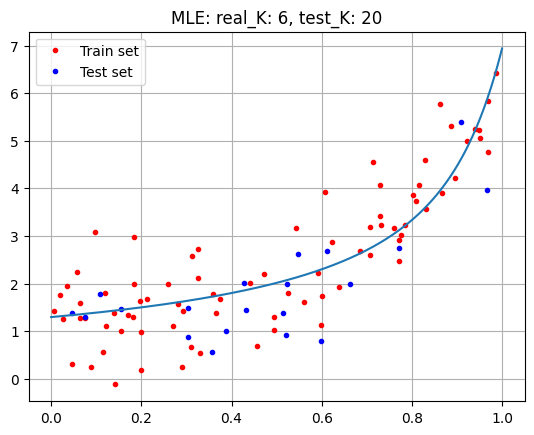



Abs error on training data is: 0.5664972802471072
Abs error on test data is: 0.5987787098734628
Error on w:0.5267745672552173


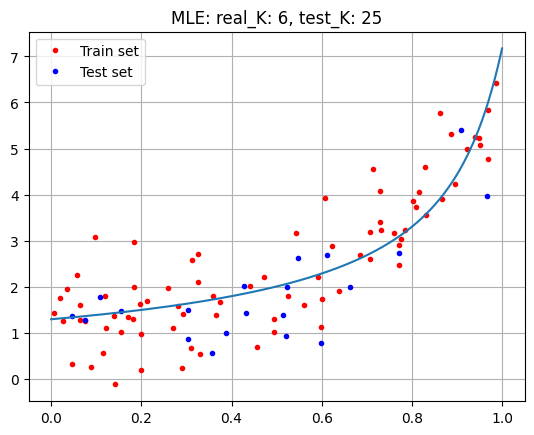



The best test K for which we have the smallest error is 10


In [444]:
K = [2,4,10,20,25]
visualize_model(train_data, test_data, K, MLE = True, algo = 'SGD')

The best tradeoff is given by K = 5


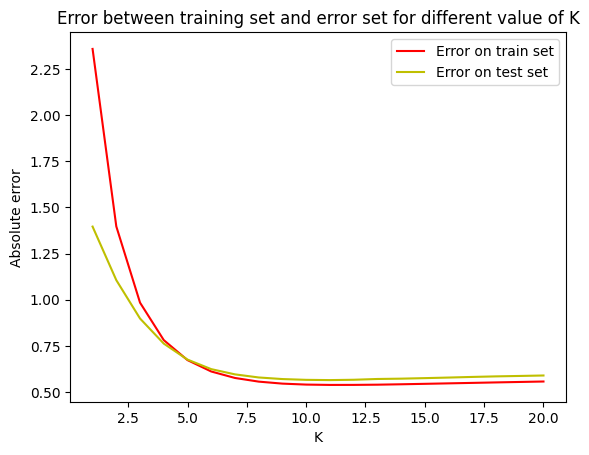

In [445]:
compare_error(train_data, test_data, Kmax = 20, MLE = True, algo = 'SGD', l = None)

###GD

Visualize the model for different K

Abs error on training data is: 1.0398996257593296
Abs error on test data is: 1.078068858361965


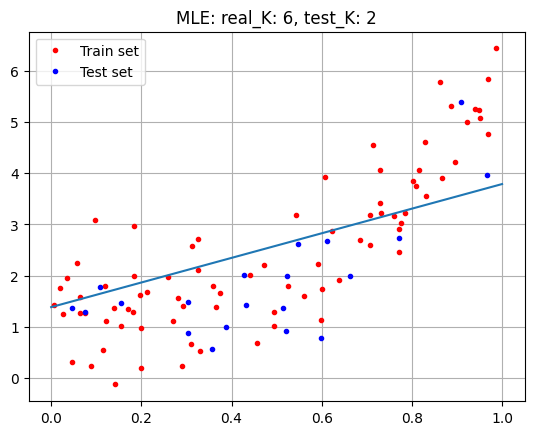



Abs error on training data is: 0.6025035060385766
Abs error on test data is: 0.6970320103264213


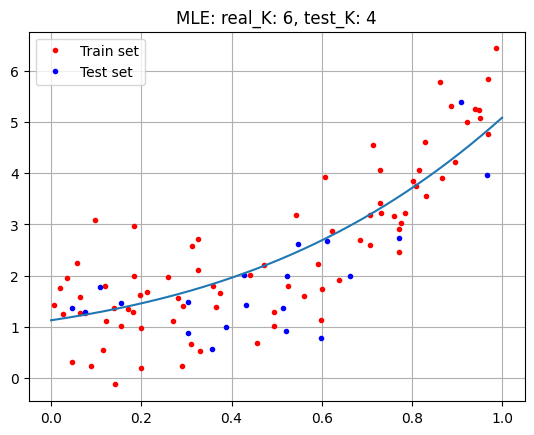



Abs error on training data is: 0.5208281101542688
Abs error on test data is: 0.5781950199299171
Error on w:0.4410953342625407


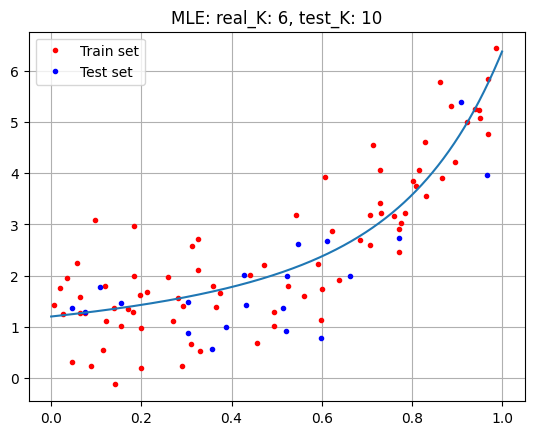



Abs error on training data is: 0.5357235056061264
Abs error on test data is: 0.6023818675573003
Error on w:0.45541939051433133


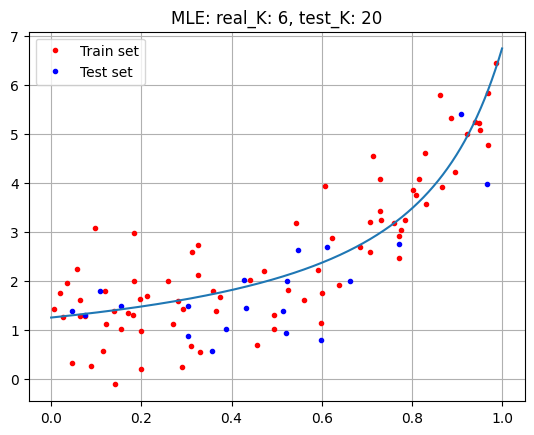



Abs error on training data is: 0.5363407183712819
Abs error on test data is: 0.6046822287066297
Error on w:0.4504169357303616


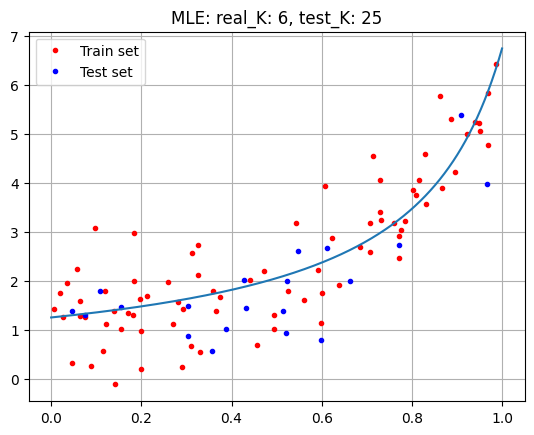



The best test K for which we have the smallest error is 10


In [446]:
K = [2,4,10,20,25]
visualize_model(train_data, test_data, K, MLE = True, algo = 'GD')

The best tradeoff is given by K = 2


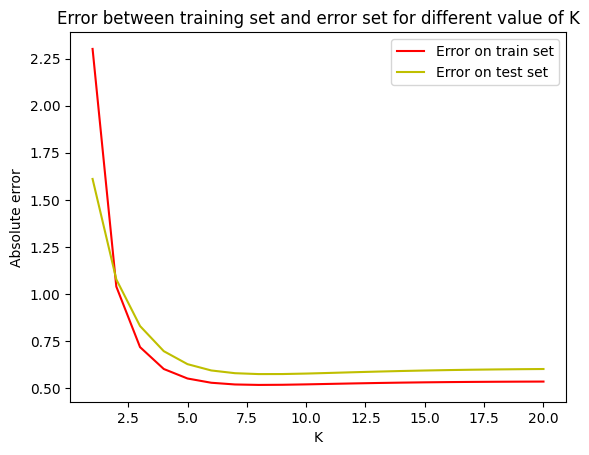

In [447]:
compare_error(train_data, test_data, Kmax = 20, MLE = True, algo = 'GD', l = None)

###NORMAL EQUATION

Visualize the model for different K

Abs error on training data is: 0.7931200687075854
Abs error on test data is: 1.0077156146625648


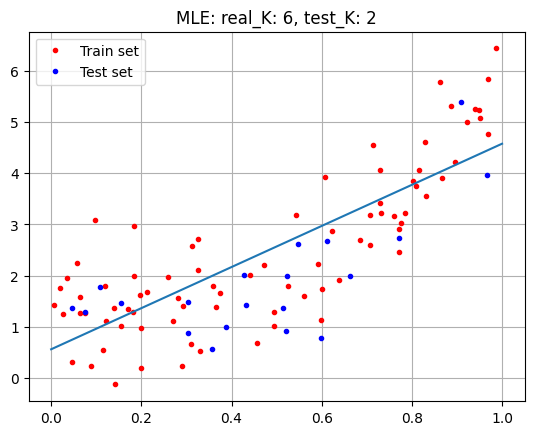



Abs error on training data is: 0.5007118555596036
Abs error on test data is: 0.4866392566427419


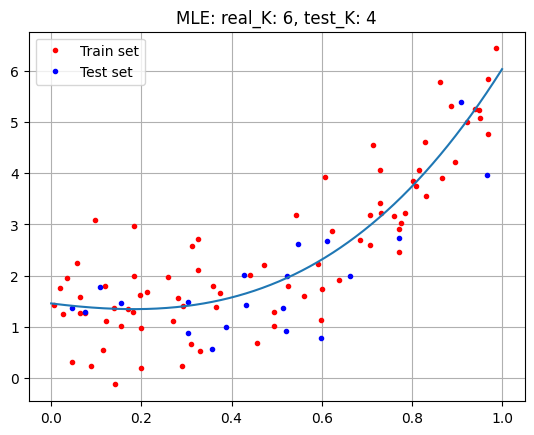



Abs error on training data is: 0.49124956908346223
Abs error on test data is: 0.4864211208119368
Error on w:101553.00582563276


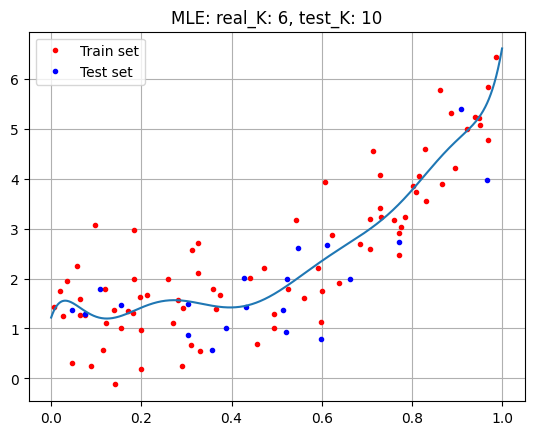



Abs error on training data is: 0.47455202675566205
Abs error on test data is: 0.45837066310957314
Error on w:1162384.3330063901


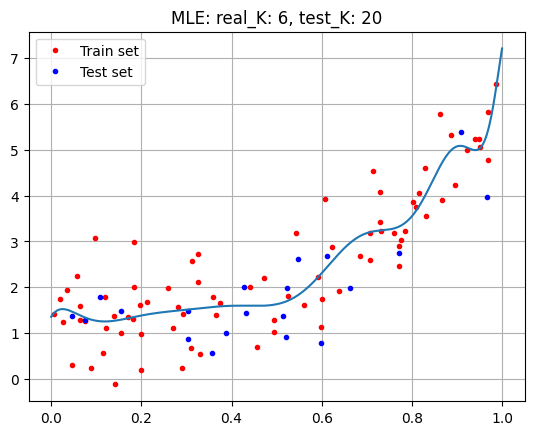



Abs error on training data is: 0.4767051725756259
Abs error on test data is: 0.47059906911159466
Error on w:40544715.67602488


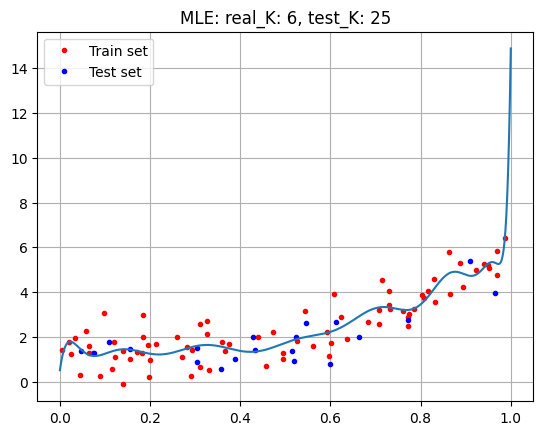



The best test K for which we have the smallest error is 20


In [448]:
K = [2,4,10,20,25]
visualize_model(train_data, test_data, K, MLE = True, algo = 'normal')

The best tradeoff is given by K = 9


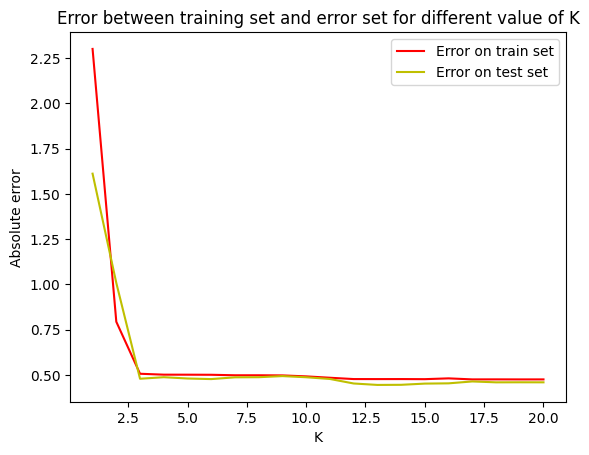

In [449]:
compare_error(train_data, test_data, Kmax = 20, MLE = True, algo = 'normal', l = None)

##MAP

###SGD

Abs error on training data is: 0.7141942347133601
Abs error on test data is: 0.5421684280838243


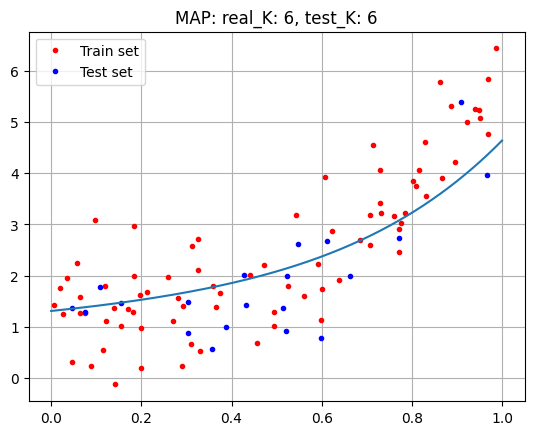

In [450]:
train_data = (Xtrain, Ytrain)
test_data = (Xtest,Ytest)
lam = [0.2, 0.4, 0.8, 2, 5, 10]
real_K = inp_K
test_K = inp_K
w = mape(train_data, K = test_K, l = 0.2, algo = 'SGD')
train_error = test(train_data, w, test_K)
test_error = test(test_data, w, test_K)
print(f"Abs error on training data is: {train_error}")
print(f"Abs error on test data is: {test_error}")
#try different value of learning rate and see how the interpolation line fits the points
real_K = inp_K
show_plot(train_data,test_data,w,real_K, test_K, MLE=False)

Visualize the model for fixed lamda and different K

Abs error on training data is: 1.613107449358969
Abs error on test data is: 0.973368161884111


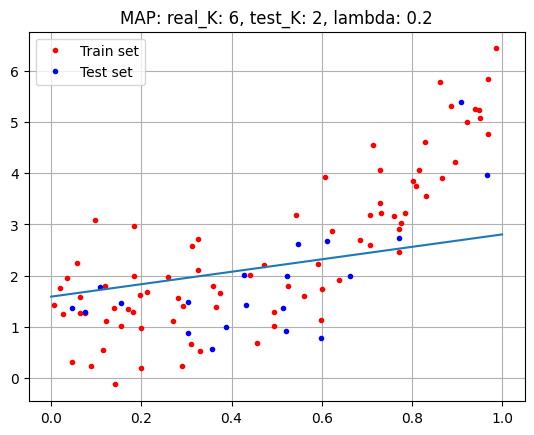



Abs error on training data is: 0.9315489440891838
Abs error on test data is: 0.6676316178053167


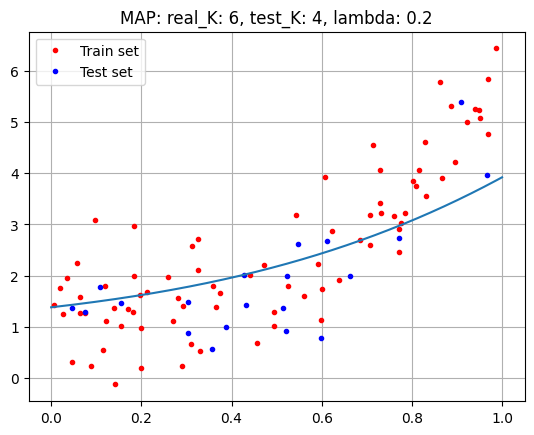



Abs error on training data is: 0.5978399612618918
Abs error on test data is: 0.481725982148132
Error on w:0.48476395870759836


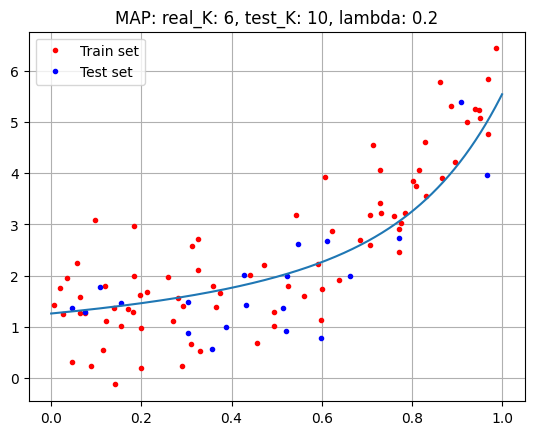



Abs error on training data is: 0.5917193847069022
Abs error on test data is: 0.5056109148846916
Error on w:0.5385880891340922


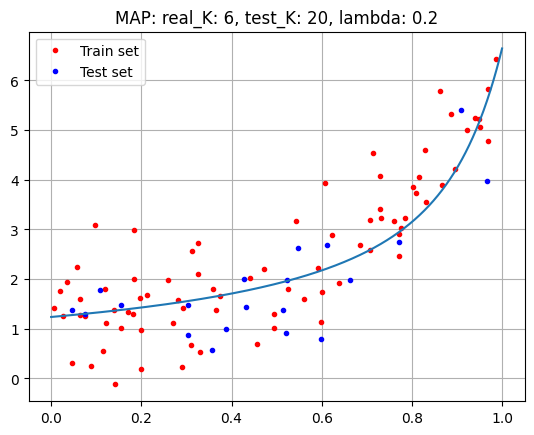



Abs error on training data is: 0.6013354195547171
Abs error on test data is: 0.5187047475332284
Error on w:0.5437907510019728


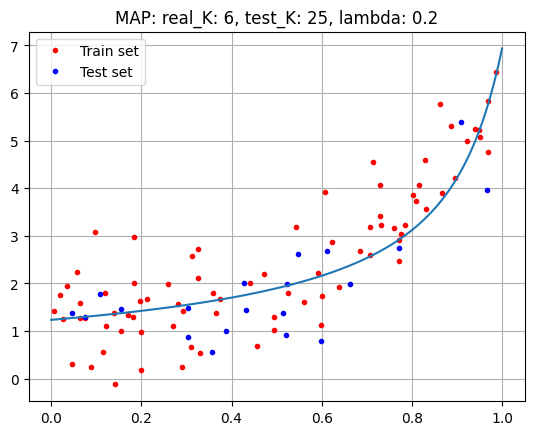



The best test K for which we have the smallest error is 10


In [451]:
l = 0.2
K = [2,4,10,20,25]
visualize_model(train_data, test_data, K, MLE = False, algo = 'SGD', l=l)

The best tradeoff is given by K = 20


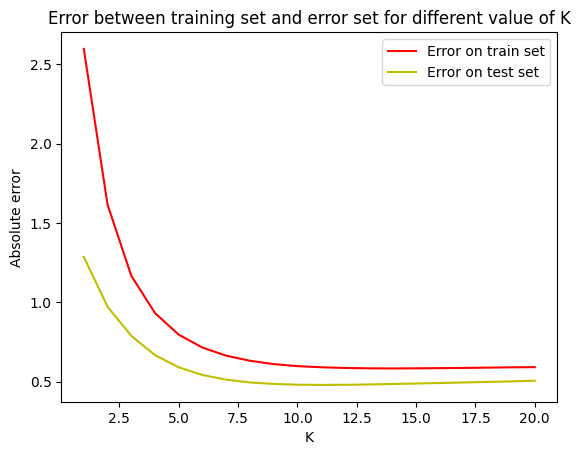

In [452]:
compare_error(train_data, test_data, Kmax = 20, MLE = False, algo = 'SGD', l = l)

Different lambda

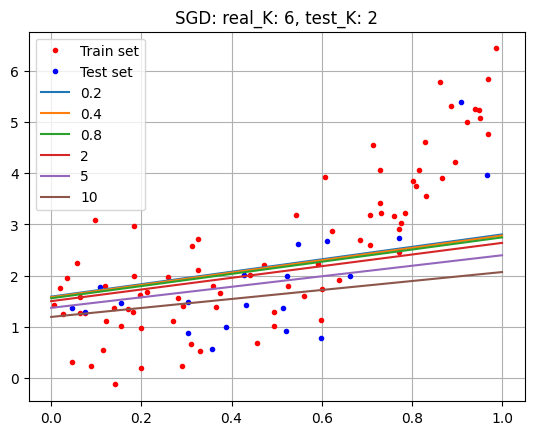

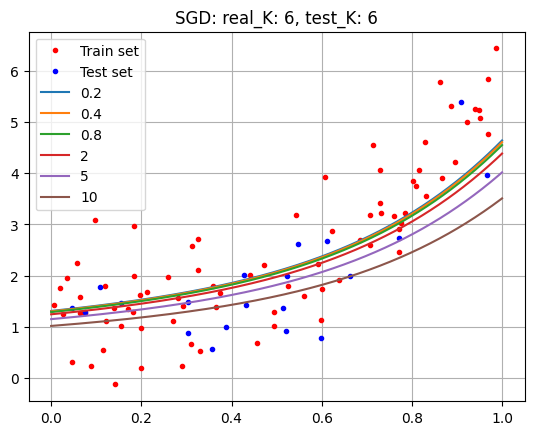

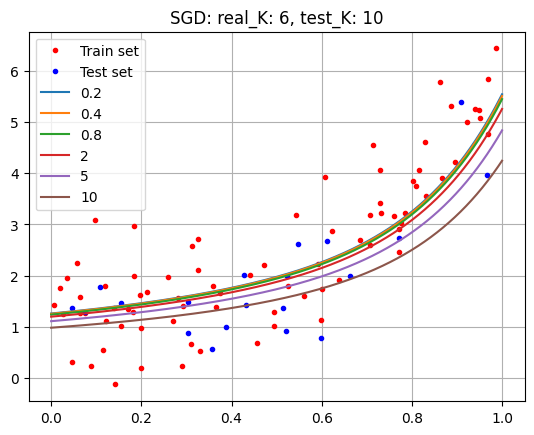

In [453]:
if (real_K -4) == 0 :
  min_K = 0
else:
  min_K = real_K - 4
fix_K = [min_K, real_K, real_K + 4]
#lam = [0.2, 0.4, 0.8]
best_k = K[0]
small_error = 0
best_l = lam[0]
for test_K in fix_K:
  show_plot_lambda(train_data, test_data, real_K, test_K, lam, algo='SGD')


###GD

Visualize the model for fixed lamda and different K

Abs error on training data is: 1.6136054493047332
Abs error on test data is: 0.9731438582827883


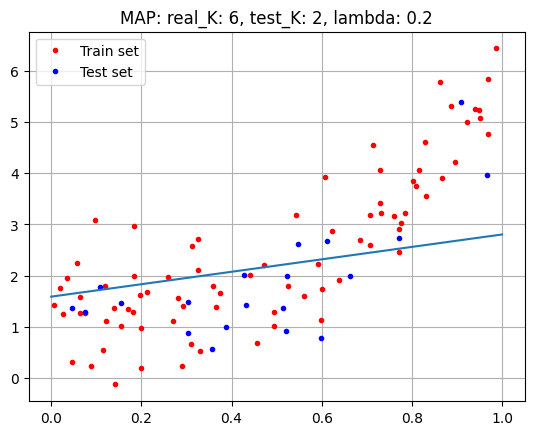



Abs error on training data is: 0.931671342823647
Abs error on test data is: 0.6675259548183253


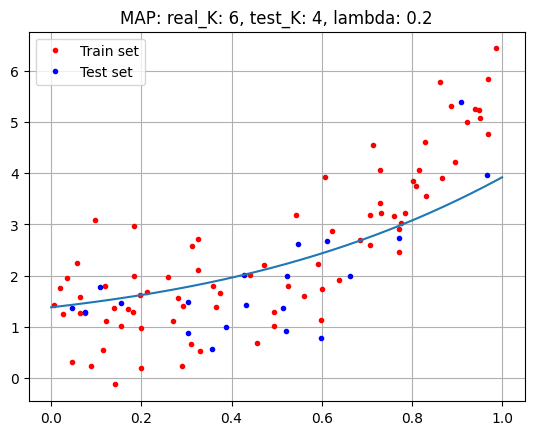



Abs error on training data is: 0.5981219804968123
Abs error on test data is: 0.4806704624194918
Error on w:0.48487684962754


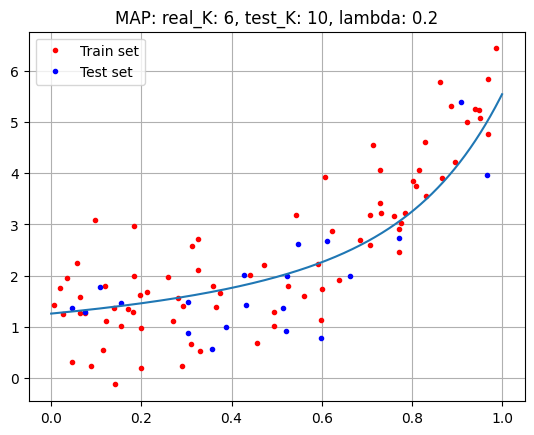



Abs error on training data is: 0.5925663264705451
Abs error on test data is: 0.5042898611737865
Error on w:0.5383410114011346


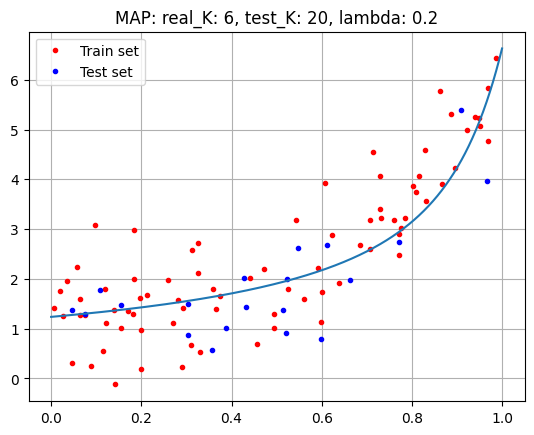



Abs error on training data is: 0.6013733303854928
Abs error on test data is: 0.5189400699523967
Error on w:0.5440256436057982


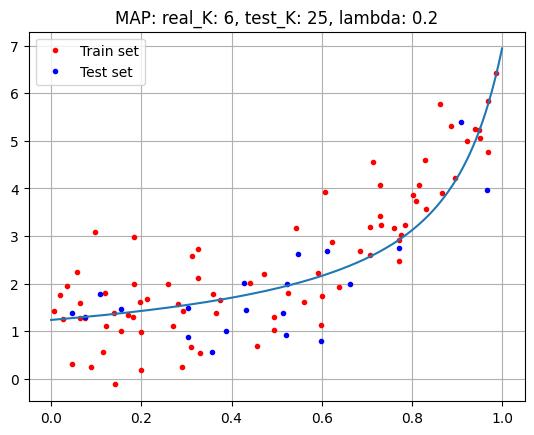



The best test K for which we have the smallest error is 10


In [454]:
l = 0.2
K = [2,4,10,20,25]
visualize_model(train_data, test_data, K, MLE = False, algo = 'GD', l=l)

The best tradeoff is given by K = 20


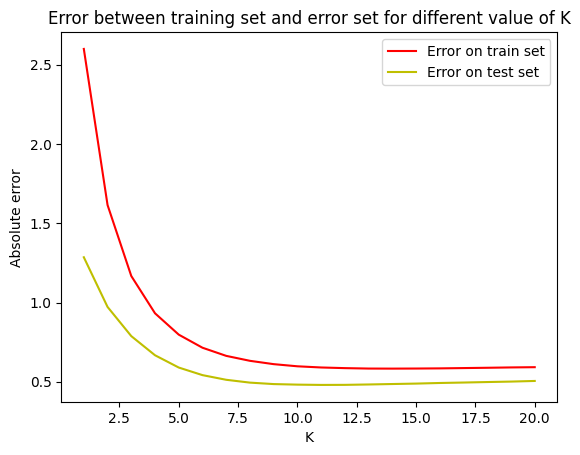

In [455]:
compare_error(train_data, test_data, Kmax = 20, MLE = False, algo = 'GD', l = l)

Different lambda

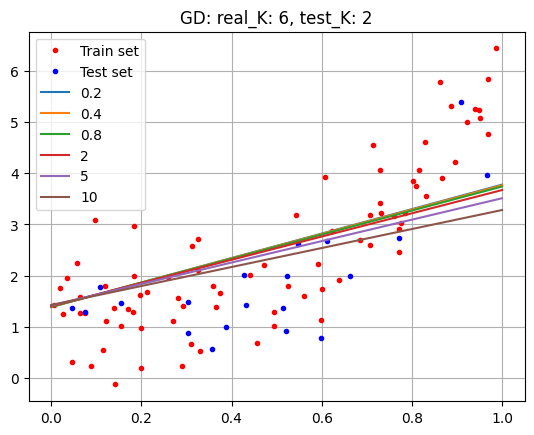

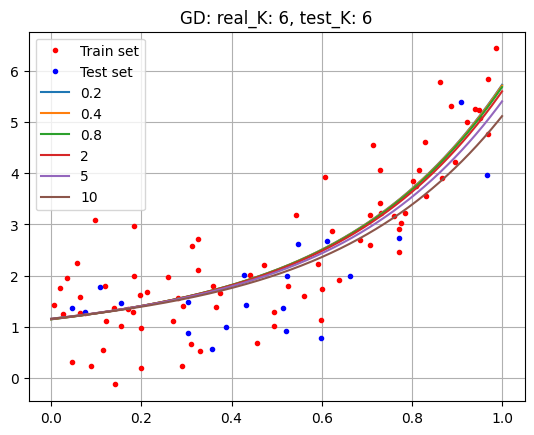

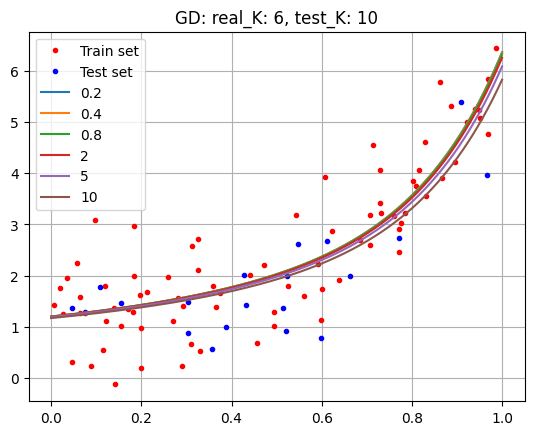

In [456]:
if (real_K -4) == 0 :
  min_K = 0
else:
  min_K = real_K - 4
fix_K = [min_K, real_K, real_K + 4]
#lam = [0.2, 0.4, 0.8]
best_k = K[0]
small_error = 0
best_l = lam[0]
for test_K in fix_K:
  show_plot_lambda(train_data, test_data, real_K, test_K, lam, algo='GD')


###NORMAL EQUATION

Visualize the model for fixed lamda and different K

Abs error on training data is: 1.612323224828041
Abs error on test data is: 0.9735762219629944


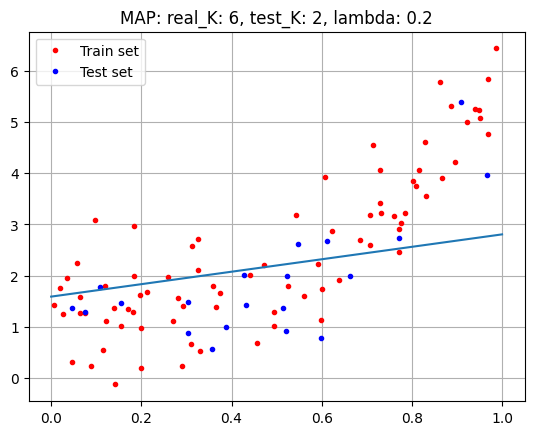



Abs error on training data is: 0.9322545899912965
Abs error on test data is: 0.6671663694836903


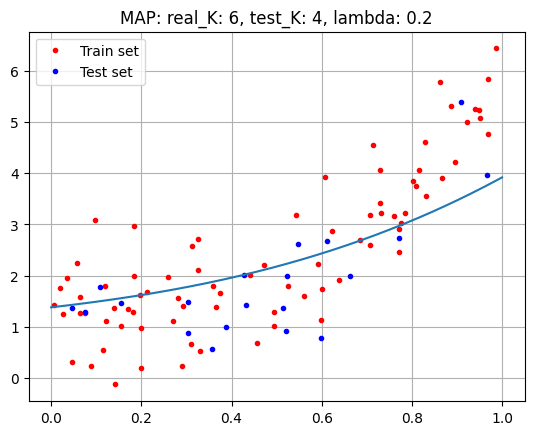



Abs error on training data is: 0.5978415382945503
Abs error on test data is: 0.4806845212962571
Error on w:0.4849316597550225


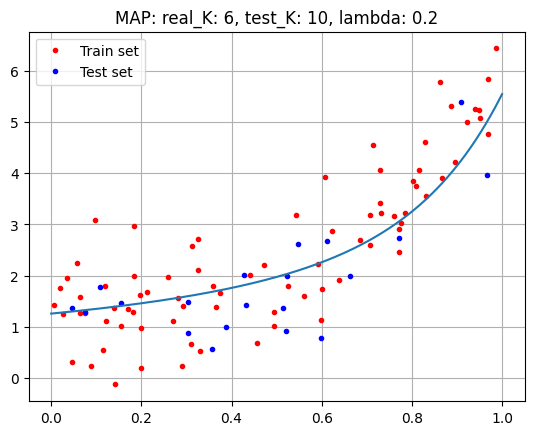



Abs error on training data is: 0.5922045973389151
Abs error on test data is: 0.5049814056215503
Error on w:0.5386776273705892


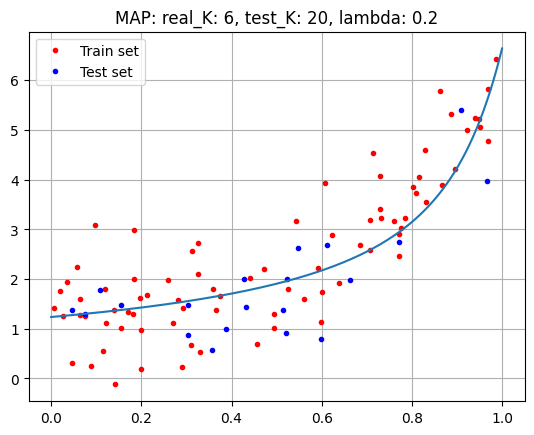



Abs error on training data is: 0.6018733992125618
Abs error on test data is: 0.51840275653474
Error on w:0.5442635810598938


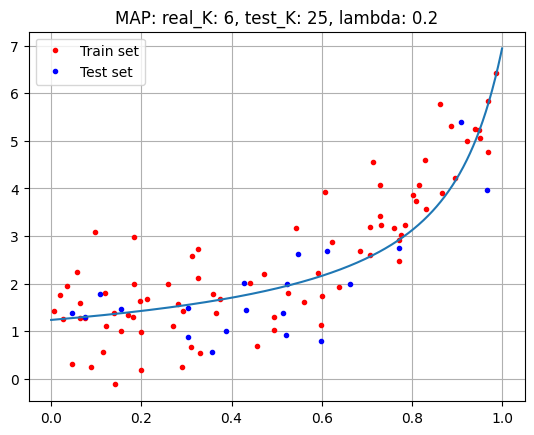



The best test K for which we have the smallest error is 10


In [457]:
l = 0.2
K = [2,4,10,20,25]
visualize_model(train_data, test_data, K, MLE = False, algo = 'normal', l=l)

The best tradeoff is given by K = 19


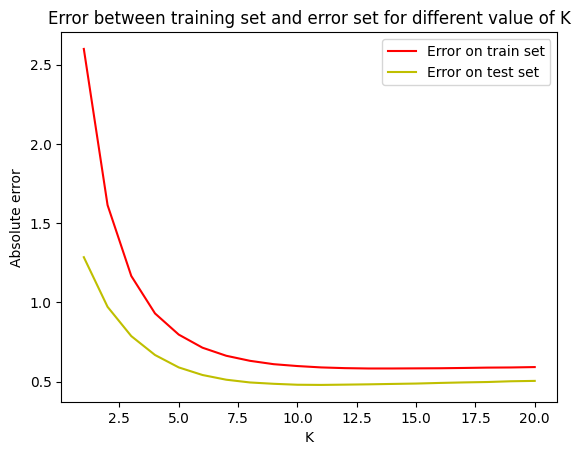

In [458]:
compare_error(train_data, test_data, Kmax = 20, MLE = False, algo = 'normal', l = l)

Different lambda

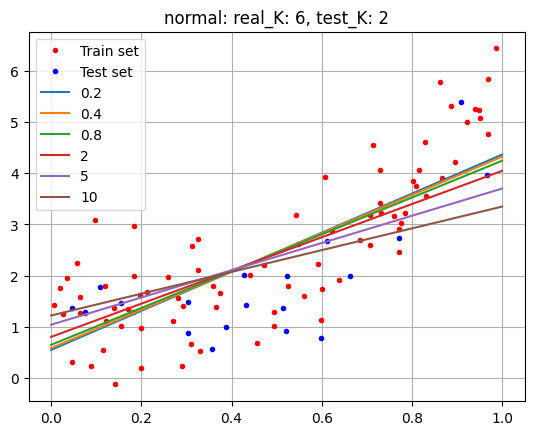

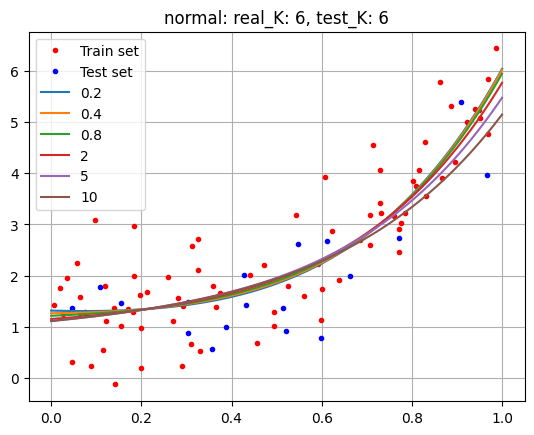

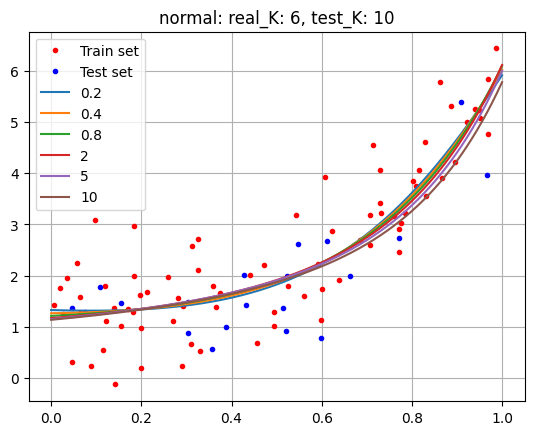

In [459]:
if (real_K -4) == 0 :
  min_K = 0
else:
  min_K = real_K - 4
fix_K = [min_K, real_K, real_K + 4]
#lam = [0.2, 0.4, 0.8]
best_k = K[0]
small_error = 0
best_l = lam[0]
for test_K in fix_K:
  show_plot_lambda(train_data, test_data, real_K, test_K, lam, algo='normal')


##Different N size

In [460]:
#get the value K
#inp_K = int(input("Enter a K>0: "))
#if(inp_K<=0):
#  raise Exception("Please put a value greater than 0")
inp_K = 6
w_true = np.ones((inp_K,))
w_true.shape

(6,)

In [461]:
a = 0
b = 1
N = 1000
X = np.random.uniform(a,b,N)
#X = np.linspace(a,b,N)
V = vander (X,inp_K)
print(V.shape)

(1000, 6)


In [462]:
#random Gaussian noise
#sigma = 0.5
variance = 0.8
mean = 0
noise = np.random.normal(mean,variance,N)
#built Y
Y = V @ w_true + noise
Y.shape

(1000,)

In [463]:
Ntrain = int(0.8*N)
(Xtrain, Ytrain), (Xtest, Ytest) = split_data(X, Y, Ntrain)
train_data = (Xtrain, Ytrain)
test_data = (Xtest, Ytest)
#print(Xtrain.shape, Xtest.shape)

To follow, it is showed the behaviour of the models using SGD and normal equation.

###MLE

---MLE with SGD---
Abs error on training data is: 0.6090487273805105
Abs error on test data is: 0.7165143586663522


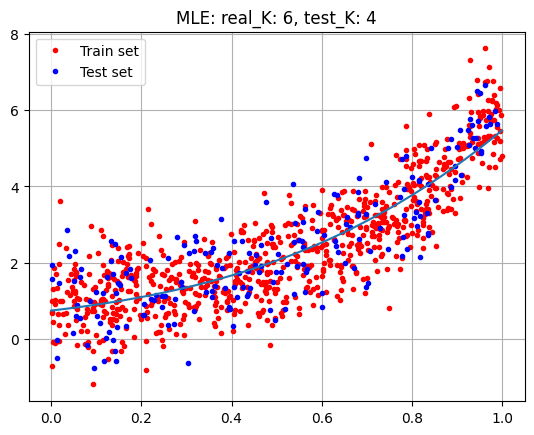



Abs error on training data is: 0.5758718901307923
Abs error on test data is: 0.682753683059981
Error on w:0.39353386297081955


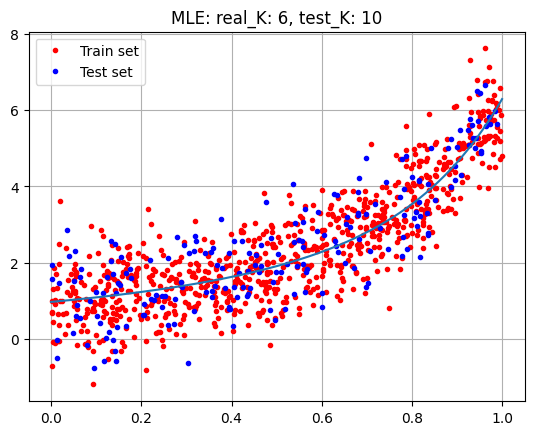



Abs error on training data is: 0.5725253318369231
Abs error on test data is: 0.6790489967932962
Error on w:0.38739497394086375


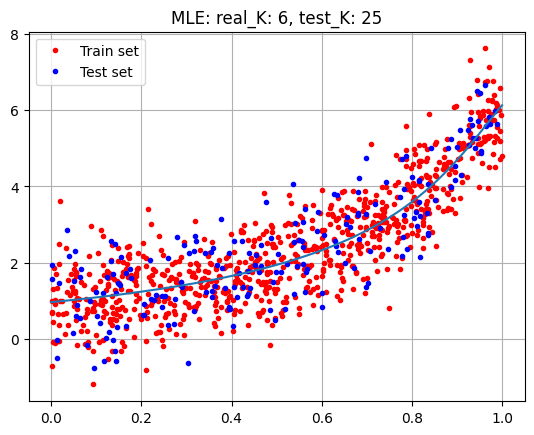



Abs error on training data is: 0.568773773555474
Abs error on test data is: 0.6768955834710861
Error on w:0.4167996702654419


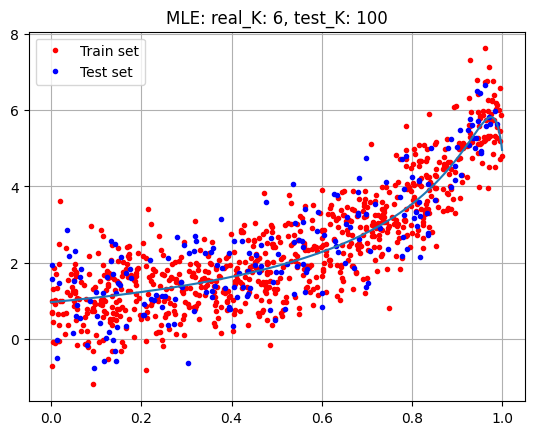



The best test K for which we have the smallest error is 100
The best tradeoff is given by K = 2


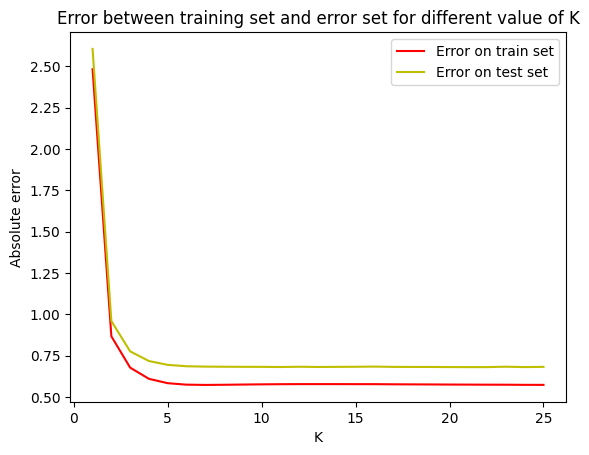

In [464]:
K = [4,10,25,100]
print('---MLE with SGD---')
visualize_model(train_data, test_data, K, MLE = True, algo = 'SGD')
compare_error(train_data, test_data, Kmax = 25, MLE = True, algo = 'SGD')

---MLE with NE---
Abs error on training data is: 0.5720704512810685
Abs error on test data is: 0.6887367785821108


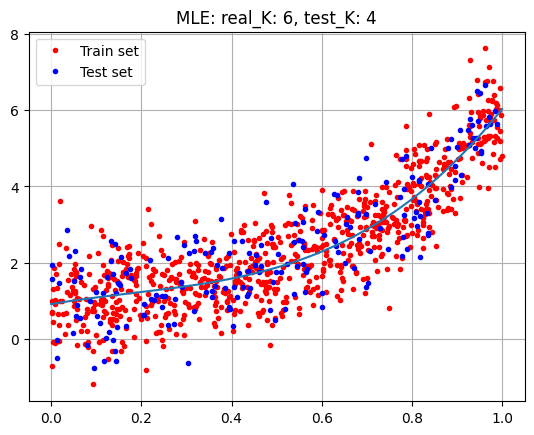



Abs error on training data is: 0.5670581879355336
Abs error on test data is: 0.6743115665938564
Error on w:7404.270298679426


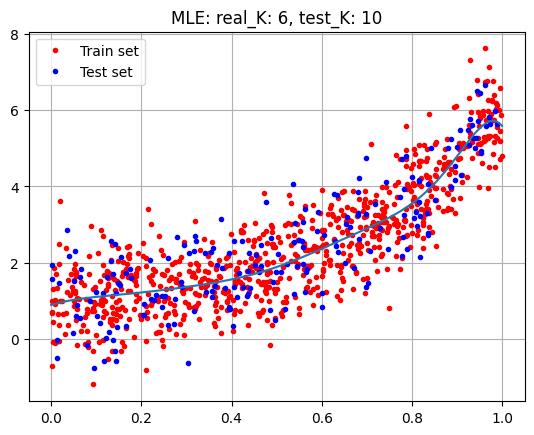



Abs error on training data is: 0.5585805214940547
Abs error on test data is: 0.6788627165845408
Error on w:2596765.9556560675


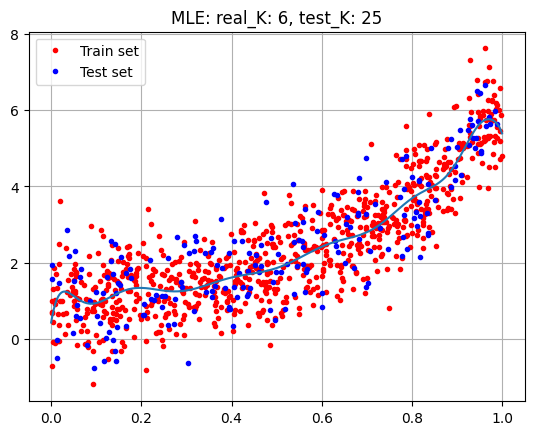



Abs error on training data is: 0.5568958735777503
Abs error on test data is: 0.6817638274934653
Error on w:20026339.71403967


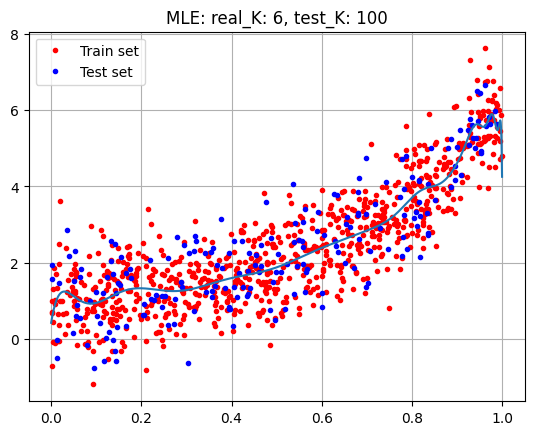



The best test K for which we have the smallest error is 10


The best tradeoff is given by K = 2


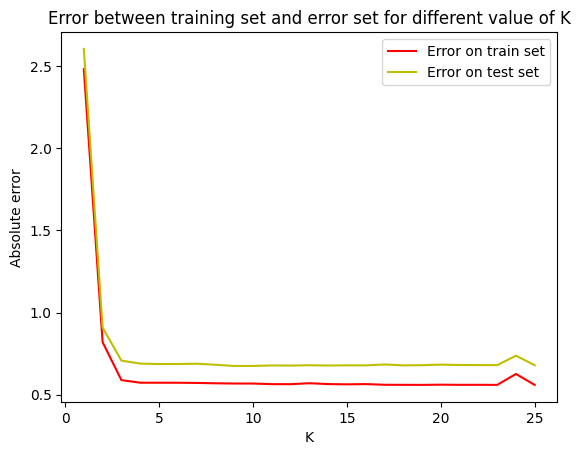

In [465]:
print('---MLE with NE---')
visualize_model(train_data, test_data, K, MLE = True, algo = 'normal')
print("\n")
compare_error(train_data, test_data, Kmax = 25, MLE = True, algo = 'normal', l = None)

###MAP

---MAP with SGD---
Abs error on training data is: 0.62289632614827
Abs error on test data is: 0.7318794992431502


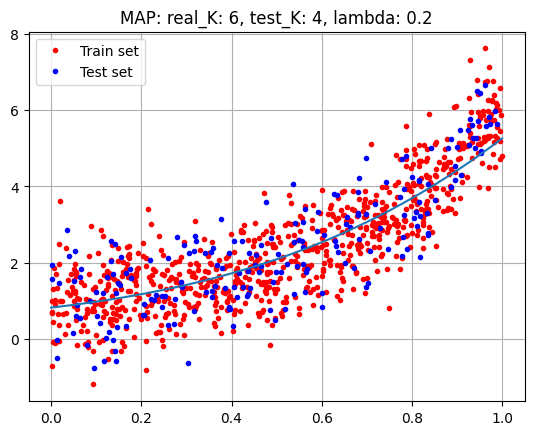



Abs error on training data is: 0.5783695519705598
Abs error on test data is: 0.6849280163529944
Error on w:0.41446966104726196


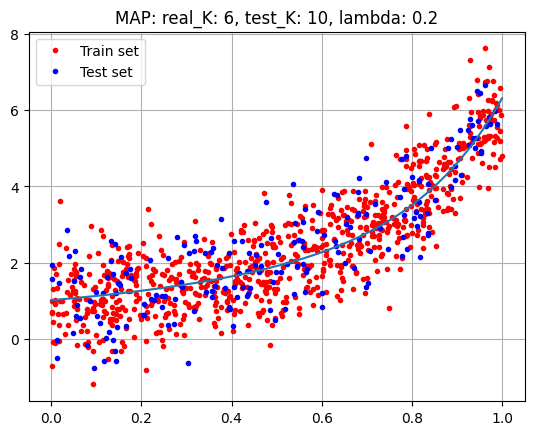



Abs error on training data is: 0.5806653718548899
Abs error on test data is: 0.6850990794461691
Error on w:0.40184260675667616


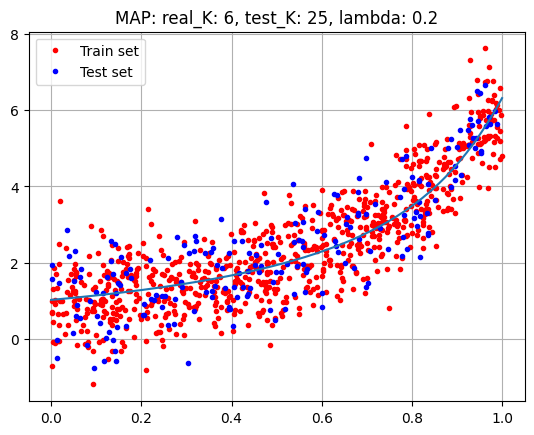



Abs error on training data is: 0.5724274175384306
Abs error on test data is: 0.6799247673271125
Error on w:0.4350655276162046


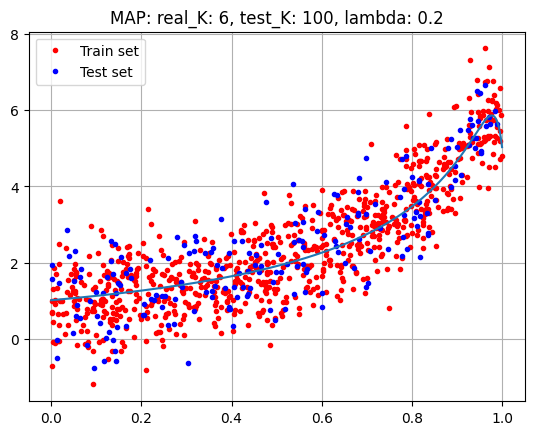



The best test K for which we have the smallest error is 100


The best tradeoff is given by K = 2


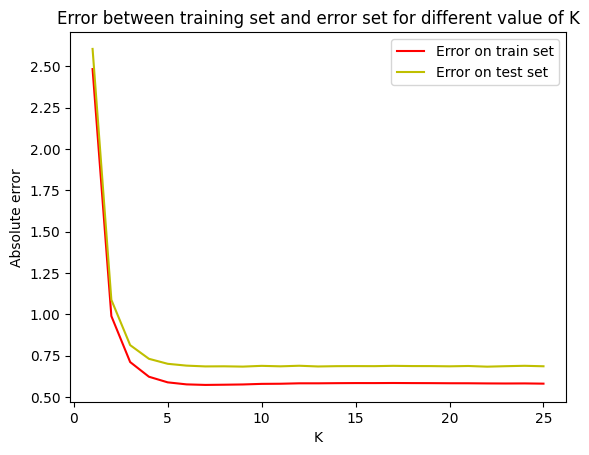

In [466]:
print('---MAP with SGD---')
l = 0.2
visualize_model(train_data, test_data, K, MLE = False, algo = 'SGD', l=l)
print("\n")
compare_error(train_data, test_data, Kmax = 25, MLE = False, algo = 'SGD', l = l)

---MAP with NE---
Abs error on training data is: 0.6228474431894834
Abs error on test data is: 0.731316500815155


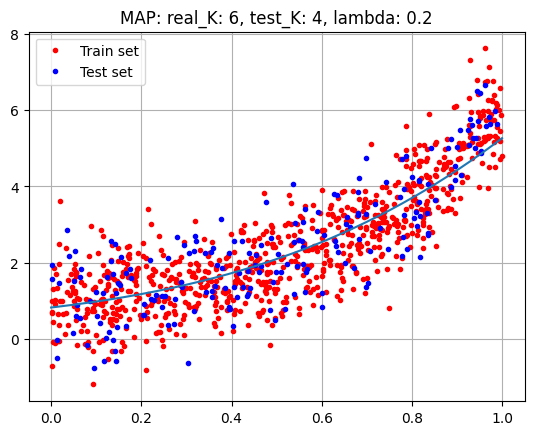



Abs error on training data is: 0.5789862710207078
Abs error on test data is: 0.6869453839007149
Error on w:0.41472837380605143


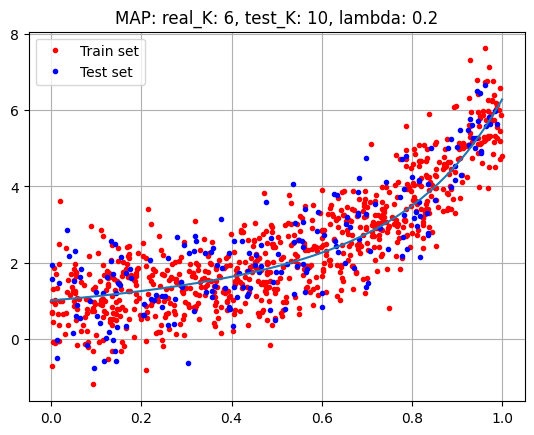



Abs error on training data is: 0.5810050507761847
Abs error on test data is: 0.686239108644454
Error on w:0.40223590248925145


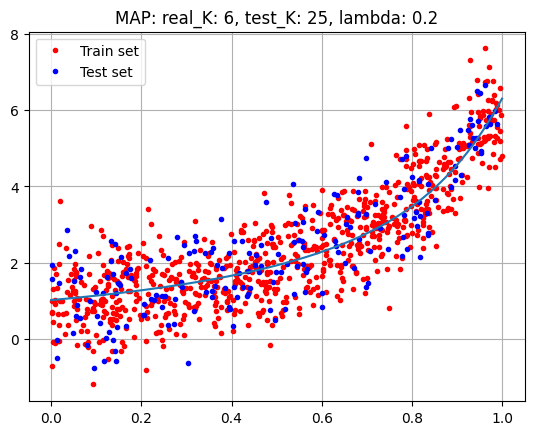



Abs error on training data is: 0.572237455915388
Abs error on test data is: 0.6796625581220852
Error on w:0.43404076381887796


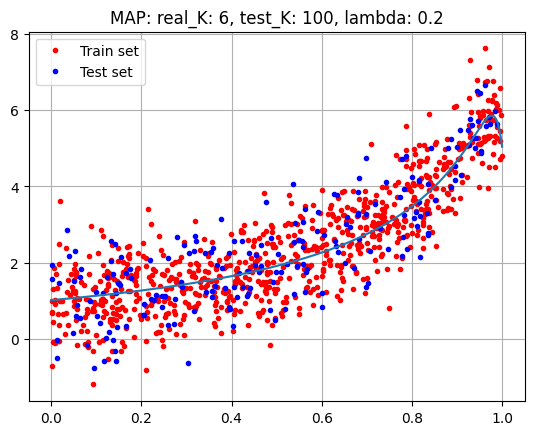



The best test K for which we have the smallest error is 100


The best tradeoff is given by K = 2


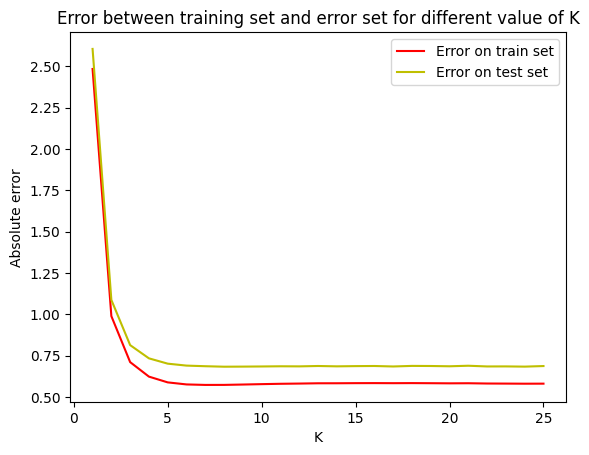

In [467]:
print('---MAP with NE---')
l = 0.2
visualize_model(train_data, test_data, K, MLE = False, algo = 'normal', l=l)
print("\n")
compare_error(train_data, test_data, Kmax = 25, MLE = False, algo = 'normal', l = l)